# RQ2

In [80]:
# for arrays
import numpy as np

# for dataframes
import pandas as pd

# plots
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse
import matplotlib.patheffects as pe

# high-level plots
import seaborn as sns

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# machine learning library
# Principal Component Analysis - determine new axis for representing data
from sklearn.decomposition import PCA
# decision trees
from sklearn.tree import DecisionTreeRegressor
# Random Forests -> vote between decision trees
# Gradient boosting -> instead of a vote, upgrade the same tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# To add interactions in linear regressions models
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OrdinalEncoder
# Elasticnet is an hybrid method between ridge and Lasso
from sklearn.linear_model import LinearRegression, ElasticNet
# support vector machines
from sklearn.svm import SVR
# To separate the data into training and test
from sklearn.model_selection import train_test_split
# Simple clustering (iterative steps)
from sklearn.cluster import KMeans
# metrics
from sklearn.metrics import mean_absolute_error

# neural network
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

# we use it to interact with the file system
import os
# compute time
from time import time, sleep

# no warning
import warnings
warnings.filterwarnings("ignore")

#### Import data about hardware

In [64]:
system_dir = './data/systems/'
hard_dir = './data/procs/'

to_keep = ['nb_models', 'ls_architecture', 'ls_cpuop-mode', 'ls_cpu', 'ls_threadpercore','ls_corepersocket', 
           'ls_socket', 'ls_numanode', 'ls_vendorid',  'ls_cpufamily', 'ls_model', 'ls_stepping', 
           'ls_cpumhz', 'ls_cpumaxmhz', 'ls_cpuminmhz', 'ls_bogomips', 'ls_virtualization',
           'ls_l1dcache', 'ls_l1icache', 'ls_l2cache', 'ls_l3cache', 'cp_vendor_id','cp_cpufamily', 'cp_model',
           'cp_stepping', 'cp_cpumhz', 'cp_cachesize', 
           'cp_physicalid', 'cp_siblings', 'cp_coreid', 'cp_cpucores', 'cp_apicid', 'cp_initialapicid',
           'cp_fpu', 'cp_fpu_exception', 'cp_cpuidlevel', 'cp_wp',
           'cp_bogomips', 'cp_clflushsize', 'cp_cache_alignment', 'cp_addresssizes', 'ls_range']

num = ['nb_models', 'ls_cpu', 'ls_threadpercore', 'ls_corepersocket', 'ls_socket', 'ls_numanode', 
       'ls_cpumhz', 'ls_cpumaxmhz', 'ls_cpuminmhz','ls_bogomips',  'ls_l1dcache', 
       'ls_l1icache', 'ls_l2cache', 'ls_l3cache', 'cp_cpumhz', 'cp_cachesize', 
       'cp_siblings', 'cp_cpucores', 'cp_fpu', 'cp_fpu_exception', 'cp_bogomips', 'ls_range']

categ = ['ls_architecture', 'ls_cpuop-mode', 'cp_addresssizes']
#

not_modif = ['ls_range']

# separate average perfs from standard deviations
def separate_perf(perf):
    raw_perf = []
    std_perf = []

    for p in perf:
        tab = str(p).replace(" ", "").split("+/-")
        raw_perf.append(tab[0])
        if len(tab) > 1:
            std_perf.append(tab[1])
        else:
            std_perf.append('')

    return (raw_perf, std_perf)

# load SKU information
envs = pd.read_csv("data/ls_cp_info_modif.csv").set_index("id")
envs = envs.query("ls_cpu!='NaN'")[to_keep]
envs = envs[num].join(pd.get_dummies(envs[categ]))

# standardise skuy info
for col in envs.columns:
    if col not in not_modif:
        envs[col] = [(k-np.mean(envs[col]))/np.std(envs[col]) for k in envs[col]]

# add profile information
for sys_name in os.listdir(system_dir):
    sys = pd.read_csv(system_dir+sys_name, index_col = 0)
    sys["id"] = [k.replace("/s/", "").replace("+", "") for k in sys["idproc"]]
    score = []
    for i in range(sys.shape[0]):
        if i <= sys.shape[0]/3:
            score.append(1)
        elif i <=sys.shape[0]*2/3:
            score.append(0)
        else:
            score.append(-1)
    sys.loc[:, sys_name[:-4]] = score
    sys = sys.set_index("id")
    sys = sys.drop(["idproc", "percentile", "descproc", "nbproc", "perf"], axis = 1)
    envs = envs.join(sys)

envs = envs.fillna('0')

scores = np.zeros(envs.shape[0])

for i in range(31, envs.shape[1]):
    scores=np.add(scores, [float(k) for k in envs[envs.columns[i]]])

envs = envs.drop(envs.columns[30:envs.shape[1]], axis=1)
envs["scores"] = [(k-np.mean(scores))/np.std(scores) for k in scores]
envs

,nb_models,ls_cpu,ls_threadpercore,ls_corepersocket,ls_socket,ls_numanode,ls_cpumhz,ls_cpumaxmhz,ls_cpuminmhz,ls_bogomips,...,ls_range,ls_cpuop-mode,cp_addresssizes,ls_architecture_aarch64,ls_architecture_armv6l,ls_architecture_armv7l,ls_architecture_i686,ls_architecture_ppc64le,ls_architecture_x86_64,scores
id,,,,,,,,,,,,,,,,,,,,,
2xAMDEPYC72528-Core,1.184474,0.257242,0.552375,-0.0469018,0.582235,0.572072,-0.0402108,-0.0160395,0.61149,0.590706,...,EPYC,-0.113755,0.238994,-0.17092,-0.033059,-0.167506,-0.208039,-0.093865,0.361752,-0.047809
2xAMDEPYC72628-Core,1.184474,0.257242,0.552375,-0.0469018,0.582235,0.572072,-0.0232675,0.0952002,0.61149,0.711693,...,EPYC,-0.113755,0.238994,-0.17092,-0.033059,-0.167506,-0.208039,-0.093865,0.361752,0.113490
2xAMDEPYC727212-Core,1.184474,0.683440,0.552375,0.26815,0.582235,0.572072,-0.024769,-0.238519,0.61149,0.355247,...,EPYC,-0.113755,0.238994,-0.17092,-0.033059,-0.167506,-0.208039,-0.093865,0.361752,0.113490
2xAMDEPYC728216-Core,1.184474,1.109637,0.552375,0.583202,0.582235,0.572072,-0.0315059,-0.349758,0.61149,0.227343,...,EPYC,-0.113755,0.238994,-0.17092,-0.033059,-0.167506,-0.208039,-0.093865,0.361752,0.395763
2xAMDEPYC730116-Core,1.184474,1.109637,0.552375,0.583202,0.582235,6.27607,-0.0421304,-1.0172,0.0395867,-0.493891,...,EPYC,-0.113755,0.238994,-0.17092,-0.033059,-0.167506,-0.208039,-0.093865,0.361752,0.032841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
POWER98-Core,-0.418152,0.257242,3.6696,-0.0469018,-0.32737,-0.378595,0,0.762638,1.88111,0,...,0,0,0,-0.17092,-0.033059,-0.167506,-0.208039,10.653638,-2.764328,-0.128458
POWER980-Core,-0.418152,1.535835,9.90405,-0.598242,7.85907,0.572072,0,0,0,0,...,0,0,0,-0.17092,-0.033059,-0.167506,-0.208039,10.653638,-2.764328,0.032841
POWER9altivecsupported44-Core,-0.418152,4.093020,3.6696,1.05578,0.582235,0.572072,0,0.762638,1.85824,0,...,0,0,0,-0.17092,-0.033059,-0.167506,-0.208039,10.653638,-2.764328,0.073166


## Clustering

### PCA

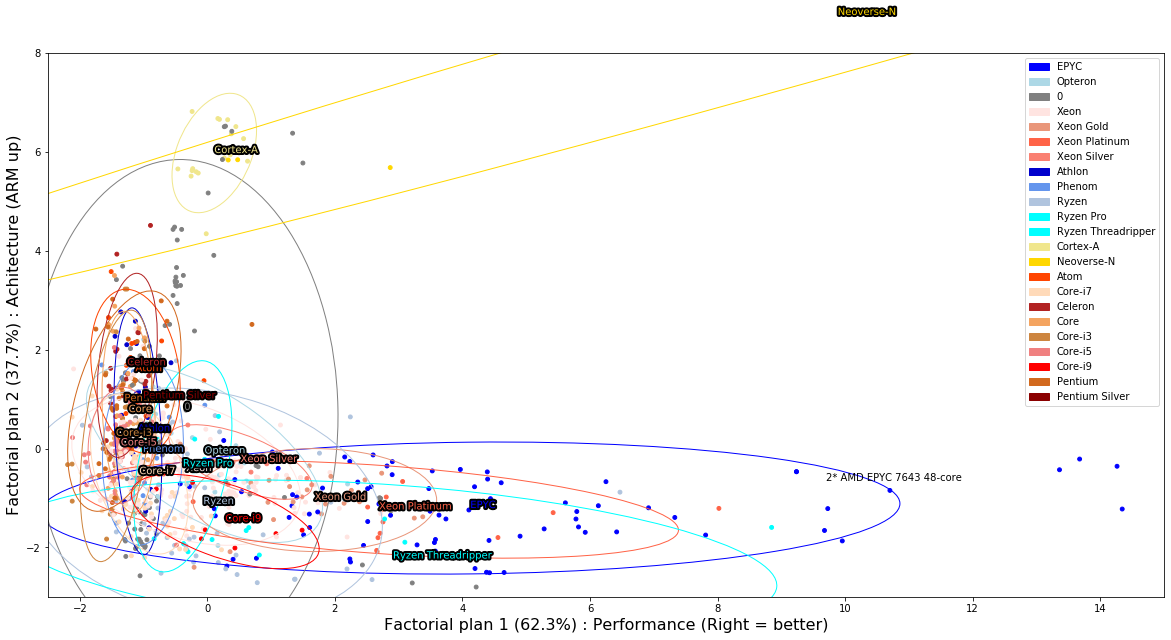

In [85]:
p = PCA(n_components=2)

pca_result = p.fit_transform(envs.drop(["ls_range"], axis=1))

values = envs["ls_range"].unique()
#['EPYC', 'Opteron', '0', 'Xeon', 'Xeon Gold', 'Xeon Platinum', 'Xeon Silver', 'Athlon',  
# 'Phenom', 'Ryzen', 'Ryzen Pro', 'Ryzen Threadripper', 'Cortex-A', 'Neoverse-N', 'Atom', 'Core-i7',
# 'Celeron', 'Core', 'Core-i3', 'Core-i5', 'Core-i9', 'Pentium', 'Pentium Silver']
colors = ['blue', 'lightblue', 'gray', 'mistyrose', 'darksalmon', 'tomato', 'salmon', 'mediumblue', 
          'cornflowerblue', 'lightsteelblue', 'aqua', 'cyan', 'khaki', 'gold', 'orangered', 
          'peachpuff','firebrick', 'sandybrown', 'peru', 'lightcoral', 'red', 'chocolate', 'darkred']
cols = [colors[np.where(values==r)[0][0]] for r in envs["ls_range"]]

plt.figure(figsize = (20, 10))
ax = plt.subplot(111)
ax.scatter(pca_result[:, 0], 
            pca_result[:, 1],
            c = cols,
            #cmap=cmap,
            s=15)

ind_xmax = np.argmax([k if k < 12 else 0 for k in pca_result[:, 0]])

plt.text(pca_result[:, 0][ind_xmax]-1, 
         pca_result[:, 1][ind_xmax]+0.2,
        "2* AMD EPYC 7643 48-core")#envs.index[ind_xmax])

pops = []
for i in range(len(colors)):
    pops.append(mpatches.Patch(color=colors[i], label=values[i]))

imp = p.explained_variance_/np.sum(p.explained_variance_)

def eigsorted(cov): 
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

for i in range(len(values)):
    v = values[i]
    x = pca_result[np.where(envs["ls_range"]==v), 0] 
    y = pca_result[np.where(envs["ls_range"]==v), 1] 
    
    cov = np.cov(x, y) 
    vals, vecs = eigsorted(cov) 
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1])) 
    w, h = 4 * np.sqrt(vals) 
    
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=w,
                  height=h,
                  angle=theta,
                  color=colors[i])
    ell.set_facecolor('none')
    plt.text(np.mean(x), np.mean(y), values[i], c = colors[i], size=10,
            path_effects=[pe.withStroke(linewidth=4, foreground="black")])
    ax.add_artist(ell)

ax.legend(handles=pops)
plt.ylabel("Factorial plan 2 ("+str(100*np.round(imp[1],3))+
           "%) : Achitecture (ARM up)", size=16)
plt.xlabel("Factorial plan 1 ("+str(100*np.round(imp[0],3))
           +"%) : Performance (Right = better)", size = 16)
plt.ylim([-3, 8])
plt.xlim([-2.5, 15])
plt.savefig("./results/pca_res_ellipse.png")
plt.show()

In [38]:
np.mean(envs.query("ls_range == 'EPYC'")["scores"])

1.0934299963389333

In [39]:
np.mean(envs.query("ls_range == 'Atom'")["scores"])

-0.13853923631765955

In [42]:
np.mean(envs.query("ls_range == 'Celeron'")["scores"])

-0.18280878214862553

In [44]:
np.mean(envs.query("ls_range == 'Core-i3'")["scores"])

-0.42764156899276684

In [45]:
np.mean(envs.query("ls_range == 'Core-i5'")["scores"])

-0.30934329164680935

In [43]:
np.mean(envs.query("ls_range == 'Core-i7'")["scores"])

-0.2576706437454596

In [41]:
np.mean(envs.query("ls_range == 'Core-i9'")["scores"])

1.0560810326159813

In [59]:
envs.to_csv("./data/hard_soft.csv")

old

In [ ]:
system_dir = './data/systems/'
hard_dir = './data/procs/'

to_keep = ['nb_models', 'ls_architecture', 'ls_cpuop-mode', 'ls_cpu', 'ls_threadpercore','ls_corepersocket', 
           'ls_socket', 'ls_numanode', 'ls_vendorid',  'ls_cpufamily', 'ls_model', 'ls_stepping', 
           'ls_cpumhz', 'ls_cpumaxmhz', 'ls_cpuminmhz', 'ls_bogomips', 'ls_virtualization',
           'ls_l1dcache', 'ls_l1icache', 'ls_l2cache', 'ls_l3cache', 'cp_vendor_id','cp_cpufamily', 'cp_model',
           'cp_stepping', 'cp_cpumhz', 'cp_cachesize', 
           'cp_physicalid', 'cp_siblings', 'cp_coreid', 'cp_cpucores', 'cp_apicid', 'cp_initialapicid',
           'cp_fpu', 'cp_fpu_exception', 'cp_cpuidlevel', 'cp_wp',
           'cp_bogomips', 'cp_clflushsize', 'cp_cache_alignment', 'cp_addresssizes', 'ls_range']

num = ['nb_models', 'ls_cpu', 'ls_threadpercore', 'ls_corepersocket', 'ls_socket', 'ls_numanode', 
       'ls_cpumhz', 'ls_cpumaxmhz', 'ls_cpuminmhz','ls_bogomips',  'ls_l1dcache', 
       'ls_l1icache', 'ls_l2cache', 'ls_l3cache', 'cp_cpumhz', 'cp_cachesize', 
       'cp_siblings', 'cp_cpucores', 'cp_fpu', 'cp_fpu_exception', 'cp_bogomips', 'ls_range']

categ = ['ls_architecture', 'ls_cpuop-mode', 'cp_addresssizes']

not_modif = ['ls_range']

# separate average perfs from standard deviations
def separate_perf(perf):
    raw_perf = []
    std_perf = []

    for p in perf:
        tab = str(p).replace(" ", "").split("+/-")
        raw_perf.append(tab[0])
        if len(tab) > 1:
            std_perf.append(tab[1])
        else:
            std_perf.append('')

    return (raw_perf, std_perf)

# load SKU information
envs = pd.read_csv("data/ls_cp_info_modif.csv").set_index("id")
envs = envs.query("ls_cpu!='NaN'")[to_keep]
envs = envs[num].join(pd.get_dummies(envs[categ]))

# standardise skuy info
for col in envs.columns:
    if col not in not_modif:
        envs[col] = [(k-np.mean(envs[col]))/np.std(envs[col]) for k in envs[col]]

# add profile information
for sys_name in os.listdir(system_dir):
    sys = pd.read_csv(system_dir+sys_name, index_col = 0)
    sys["id"] = [k.replace("/s/", "").replace("+", "") for k in sys["idproc"]]
    sys = sys.set_index("id")
    avg, std = separate_perf(sys["perf"])
    avg_num = [float(k) if k!='' else None for k in avg]
    sys.loc[:, sys_name[:-4]] = [(float(k)-np.nanmean(avg_num))/np.nanstd(avg_num)
                                 if k!=None else 0 for k in avg_num]
    sys = sys.drop(["idproc", "percentile", "descproc", "nbproc", "perf"], axis = 1)
    envs = envs.join(sys)

envs = envs.fillna('0')
envs.head()